In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

from prophet import Prophet

/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [64]:
data = pd.read_csv('transaction_data_with_seasonality_100k.csv', parse_dates=['transaction_date'])

In [65]:
item_id = 1

In [66]:
data.set_index('transaction_date', inplace=True)

In [67]:
daily_data = data.groupby(['item_id']).resample('D').agg({
    'quantity': 'sum',
    'price': 'mean'
}).reset_index().fillna(method='ffill')

In [68]:
daily_data

,item_id,transaction_date,quantity,price
0,1,2019-01-01,37,28.163286
1,1,2019-01-02,22,31.694365
2,1,2019-01-03,8,12.728952
3,1,2019-01-04,11,37.025888
4,1,2019-01-05,9,11.726826
...,...,...,...,...
40475,20,2024-07-12,5,59.483621
40476,20,2024-07-13,4,18.324955
40477,20,2024-07-14,8,17.548677
40478,20,2024-07-15,1,58.698119


In [46]:
item_data = daily_data[(daily_data['item_id'] == item_id)] 
item_data.set_index('transaction_date', inplace=True) 


<Axes: xlabel='transaction_date'>

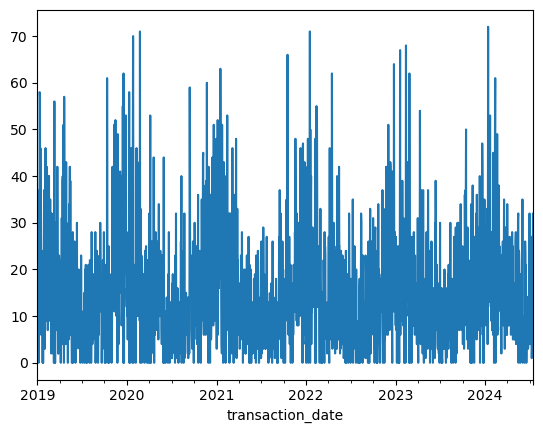

In [47]:
item_data['quantity'].plot()

In [48]:
# Split the data into train and test sets
train_size = int(len(item_data) * 0.8) 
train_data, test_data = item_data[:train_size], item_data[train_size:] 


In [49]:
model = SARIMAX(train_data['quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Annual seasonality
model_fit = model.fit(disp=False) 


/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [51]:
# Forecast
forecast = model_fit.forecast(steps=len(test_data))

# Evaluate the model
mse = mean_squared_error(test_data['quantity'], forecast)
rmse = np.sqrt(mse)
print(f'RMSE (Daily): {rmse}')

RMSE (Daily): 12.741120682414934


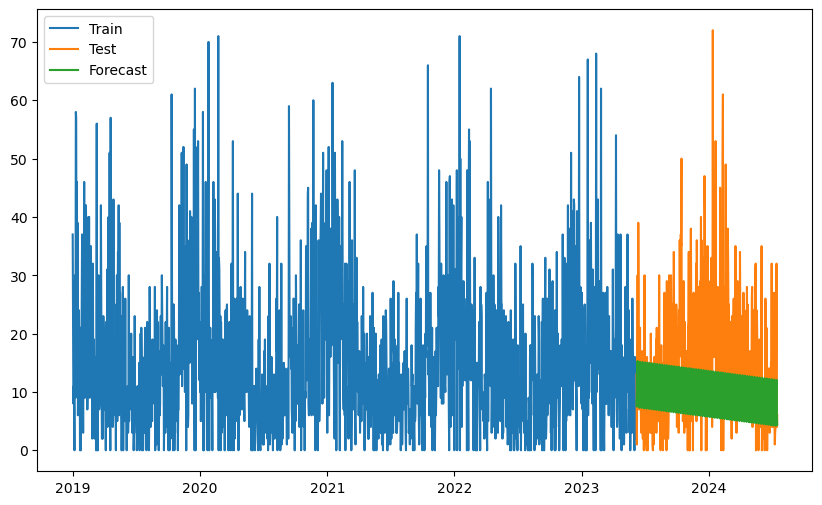

In [52]:

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['quantity'], label='Train')
plt.plot(test_data.index, test_data['quantity'], label='Test')
plt.plot(test_data.index, forecast, label='Forecast')
plt.legend()
plt.show()

## Data Preprocessing

In [88]:
daily_data.head()

,item_id,transaction_date,quantity,price
0,1,2019-01-01,37,28.163286
1,1,2019-01-02,22,31.694365
2,1,2019-01-03,8,12.728952
3,1,2019-01-04,11,37.025888
4,1,2019-01-05,9,11.726826


In [89]:
p_daily_data = daily_data.copy()

In [71]:

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# p_daily_data[['quantity', 'price']] = scaler.fit_transform(p_daily_data[['quantity', 'price']])


In [90]:
p_daily_data['day_of_week'] = p_daily_data['transaction_date'].dt.dayofweek
p_daily_data['month'] = p_daily_data['transaction_date'].dt.month


In [91]:
p_daily_data.head()

,item_id,transaction_date,quantity,price,day_of_week,month
0,1,2019-01-01,37,28.163286,1,1
1,1,2019-01-02,22,31.694365,2,1
2,1,2019-01-03,8,12.728952,3,1
3,1,2019-01-04,11,37.025888,4,1
4,1,2019-01-05,9,11.726826,5,1


In [92]:
# Add lag features
p_daily_data['lag_1'] = p_daily_data['quantity'].shift(1)
p_daily_data['lag_7'] = p_daily_data['quantity'].shift(7)
p_daily_data['lag_30'] = p_daily_data['quantity'].shift(30)


In [93]:
# Add rolling statistics
p_daily_data['rolling_mean_7'] = p_daily_data['quantity'].rolling(window=7).mean()
p_daily_data['rolling_std_7'] = p_daily_data['quantity'].rolling(window=7).std()
p_daily_data['rolling_mean_30'] = p_daily_data['quantity'].rolling(window=30).mean()
p_daily_data['rolling_std_30'] = p_daily_data['quantity'].rolling(window=30).std()


In [94]:
# Ensure no missing values in new features
p_daily_data.fillna(0, inplace=True)

In [95]:

p_item_data = p_daily_data[(p_daily_data['item_id'] == item_id)]
p_item_data.set_index('transaction_date', inplace=True)


In [96]:
# Split the data into train and test sets
train_size = int(len(p_item_data) * 0.8)
train_data, test_data = p_item_data[:train_size], p_item_data[train_size:]


In [79]:
p_item_data

,item_id,quantity,price,day_of_week,month,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30
transaction_date,,,,,,,,,,,,
2019-01-01,1,1.756523,-0.234427,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-02,1,0.557992,0.100851,2,1,1.756523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-03,1,-0.560637,-1.699929,3,1,0.557992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-04,1,-0.320931,0.607083,4,1,-0.560637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-05,1,-0.480735,-1.795081,5,1,-0.320931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-12,1,-0.800343,0.140777,4,7,-0.880245,-0.880245,0.877600,-0.572052,0.709328,-0.416813,0.625781
2024-07-13,1,0.318286,-1.727668,5,7,-0.800343,-0.400833,0.637894,-0.469320,0.786171,-0.427467,0.609721
2024-07-14,1,1.357013,1.364460,6,7,0.318286,0.957502,-0.800343,-0.412247,0.911524,-0.355555,0.686601


In [97]:
# Define the exogenous features
exog_features = ['price', 'day_of_week', 'month', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_30', 'rolling_std_30']


In [98]:
# Train the model
model = SARIMAX(train_data['quantity'], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 7),  # Weekly seasonality
                exog=train_data[exog_features])
model_fit = model.fit(disp=False)

/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [99]:
# Forecast
train_forecast = model_fit.forecast(steps=len(train_data), exog=train_data[exog_features])
test_forecast = model_fit.forecast(steps=len(test_data), exog=test_data[exog_features])

In [100]:
# Evaluate the model
mse = mean_squared_error(test_data['quantity'], test_forecast)
rmse = np.sqrt(mse)
print(f'SARIMAX RMSE: {rmse}')

SARIMAX RMSE: 68.2698952453096


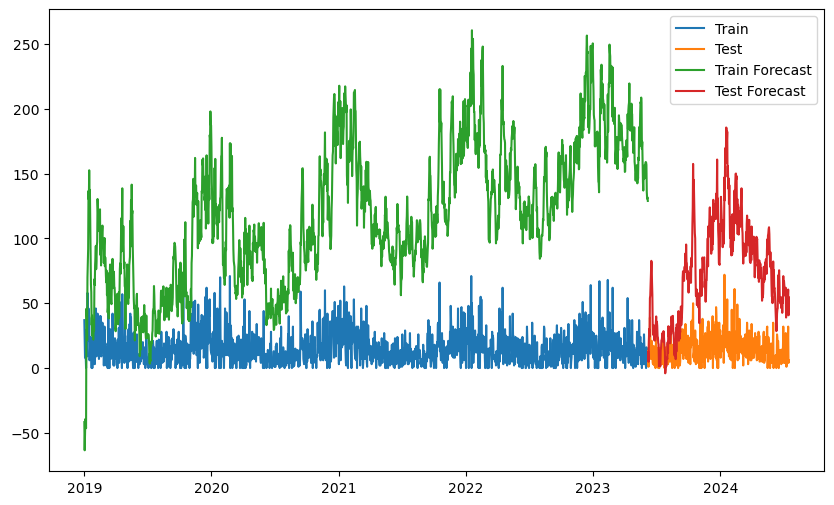

In [101]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['quantity'], label='Train')
plt.plot(test_data.index, test_data['quantity'], label='Test')
plt.plot(train_data.index, train_forecast, label='Train Forecast')
plt.plot(test_data.index, test_forecast, label='Test Forecast')
plt.legend()
plt.show()

# Prophet

In [25]:
item_data.head()

,item_id,quantity,price
transaction_date,,,
2019-01-01,1,37,28.163286
2019-01-02,1,22,31.694365
2019-01-03,1,8,12.728952
2019-01-04,1,11,37.025888
2019-01-05,1,9,11.726826


In [26]:
item_data_prophet = item_data.reset_index()[['transaction_date', 'quantity']].rename(columns={'transaction_date': 'ds', 'quantity': 'y'})


In [27]:
train_size = int(len(item_data_prophet) * 0.8)
train_data, test_data = item_data_prophet[:train_size], item_data_prophet[train_size:]


In [28]:
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
model.fit(train_data)

21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Make future dataframe and forecast
future = model.make_future_dataframe(periods=len(test_data), freq='D')
forecast = model.predict(future)

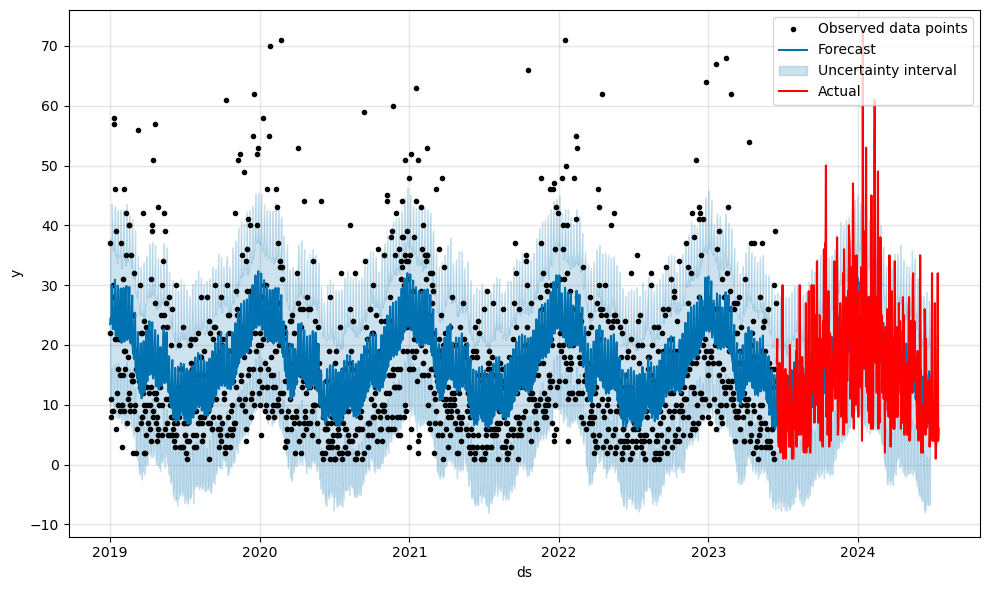

In [32]:
# Plot the forecast
fig = model.plot(forecast)
plt.plot(test_data['ds'], test_data['y'], 'r', label='Actual')
plt.legend()
plt.show()

In [43]:
pd.DataFrame({"date":test_data['ds'], "test":test_data['y'], "forecast":forecast['yhat']}).dropna()

,date,test,forecast
1499,2023-06-17,17.0,13.133192
1500,2023-06-18,21.0,15.454396
1501,2023-06-19,9.0,7.807278
1502,2023-06-20,9.0,6.575668
1503,2023-06-21,4.0,7.607462
...,...,...,...
1869,2024-07-12,5.0,6.891102
1870,2024-07-13,19.0,13.332920
1871,2024-07-14,32.0,15.598670
1872,2024-07-15,4.0,7.878473


# Preprocessing and Feature Engineering

In [102]:
p_item_data_prophet = p_item_data[['quantity']].reset_index().rename(columns={'transaction_date': 'ds', 'quantity': 'y'})


In [107]:
p_item_data

,item_id,quantity,price,day_of_week,month,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30
transaction_date,,,,,,,,,,,,
2019-01-01,1,37,28.163286,1,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2019-01-02,1,22,31.694365,2,1,37.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2019-01-03,1,8,12.728952,3,1,22.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2019-01-04,1,11,37.025888,4,1,8.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2019-01-05,1,9,11.726826,5,1,11.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-12,1,5,32.114854,4,7,4.0,4.0,26.0,7.857143,8.877473,9.800000,7.831854
2024-07-13,1,19,12.436805,5,7,5.0,10.0,23.0,9.142857,9.839183,9.666667,7.630851
2024-07-14,1,32,45.002414,6,7,19.0,27.0,5.0,9.857143,11.408017,10.566667,8.593034


In [103]:
# Adding additional regressors
p_item_data_prophet['price'] = p_item_data['price'].values
p_item_data_prophet['day_of_week'] = p_item_data['day_of_week'].values
p_item_data_prophet['month'] = p_item_data['month'].values


In [104]:
train_size = int(len(p_item_data_prophet) * 0.8)
train_data, test_data = p_item_data_prophet[:train_size], p_item_data_prophet[train_size:]


In [105]:
# Define and fit the model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
model.add_regressor('price')
model.add_regressor('day_of_week')
model.add_regressor('month')
model.fit(train_data)

23:08:00 - cmdstanpy - INFO - Chain [1] start processing
23:08:01 - cmdstanpy - INFO - Chain [1] done processing


In [122]:
# Make future dataframe and forecast
future = model.make_future_dataframe(periods=len(test_data), freq='D')

print(future.shape, test_data.shape)

(2024, 1) (405, 5)


In [123]:
future = future.loc[len(train_data):]

In [124]:
future['price'] = test_data['price'].values
future['day_of_week'] = test_data['day_of_week'].values
future['month'] = test_data['month'].values

forecast = model.predict(future)

In [125]:
# Evaluate the model
mse = mean_squared_error(test_data['y'], forecast['yhat'][:len(test_data)])
rmse = np.sqrt(mse)
print(f'Prophet RMSE: {rmse}')

Prophet RMSE: 9.970358054695245


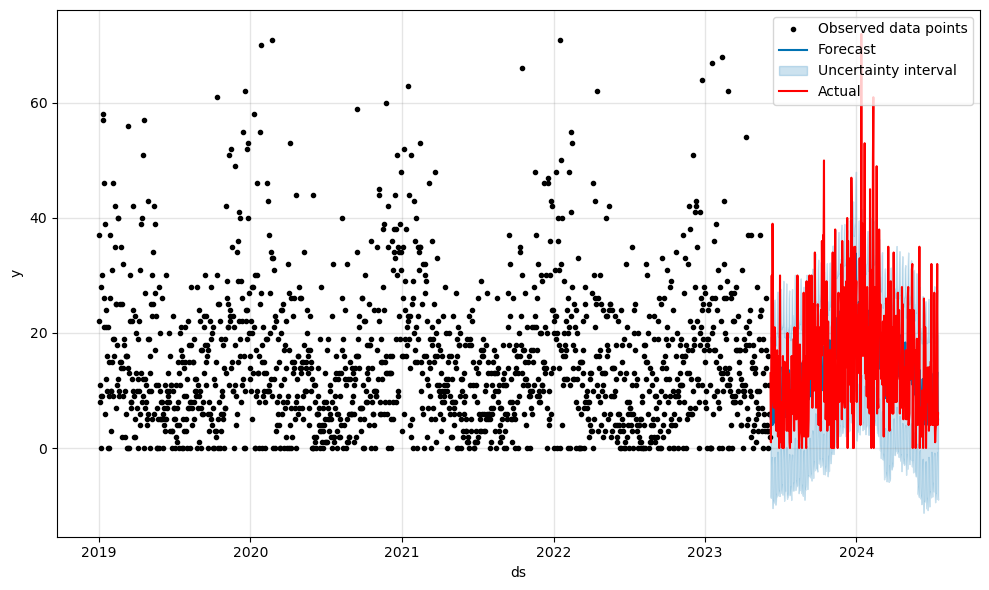

In [126]:
# Plot the forecast
fig = model.plot(forecast) 
plt.plot(test_data['ds'], test_data['y'], 'r', label='Actual') 
plt.legend() 
plt.show() 

In [130]:
pd.DataFrame({"date":test_data['ds'], "test":test_data['y'], "forecast":forecast['yhat']}) 

,date,test,forecast
0,NaT,NaN,5.667726
1,NaT,NaN,4.943269
2,NaT,NaN,11.021664
3,NaT,NaN,12.092593
4,NaT,NaN,5.904870
...,...,...,...
2019,2024-07-12,5.0,NaN
2020,2024-07-13,19.0,NaN
2021,2024-07-14,32.0,NaN
2022,2024-07-15,4.0,NaN


In [129]:
test_data

,ds,y,price,day_of_week,month
1619,2023-06-08,13,36.017004,3,6
1620,2023-06-09,1,44.462048,4,6
1621,2023-06-10,16,56.352367,5,6
1622,2023-06-11,30,27.904738,6,6
1623,2023-06-12,14,43.257910,0,6
...,...,...,...,...,...
2019,2024-07-12,5,32.114854,4,7
2020,2024-07-13,19,12.436805,5,7
2021,2024-07-14,32,45.002414,6,7
2022,2024-07-15,4,37.390353,0,7
